# **GRU MODEL - IMDb Dataset**

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.datasets import imdb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

In [5]:
# Cek apakah CUDA tersedia dan gunakan GPU jika memungkinkan
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **PYTORCH**

In [6]:
# Load IMDb Dataset
num_words = 30000  # Set the max number of words for the dataset
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)

In [7]:
# Pad the sequences to a fixed length
maxlen = 300  # You can change this to 500 for different sequence length
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

In [8]:
# Convert data to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.long).to(device)
x_test_tensor = torch.tensor(x_test, dtype=torch.long).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float).to(device)

In [9]:
# Define the GRU model
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(input_dim, 128)
        self.gru = nn.GRU(128, hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        out, hn = self.gru(x)
        out = hn[-1]  # Take the last hidden state from the GRU
        out = self.fc1(out)
        out = self.fc2(out)
        return self.sigmoid(out)

In [10]:
# Hyperparameters
input_dim = num_words  # Number of words in vocabulary
hidden_dim = 64  # Hidden layer dimensions
output_dim = 1  # Binary classification

In [11]:
# Initialize the model, loss function, and optimizer
model = GRUModel(input_dim, hidden_dim, output_dim).to(device)
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
# Training loop
num_epochs = 5
batch_size = 32
train_loader = DataLoader(list(zip(x_train_tensor, y_train_tensor)), batch_size=batch_size, shuffle=True)

In [13]:
# Track loss and accuracy for plotting
train_loss = []
train_accuracy = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for batch in train_loader:
        inputs, labels = batch
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = loss_fn(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Get predictions
        preds = outputs.squeeze().round()  # Round to get 0 or 1
        correct_preds += (preds == labels).sum().item()
        total_preds += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    accuracy = correct_preds / total_preds
    train_loss.append(epoch_loss)
    train_accuracy.append(accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch 1/5, Loss: 0.5359, Accuracy: 0.7220
Epoch 2/5, Loss: 0.3280, Accuracy: 0.8637
Epoch 3/5, Loss: 0.1965, Accuracy: 0.9254
Epoch 4/5, Loss: 0.1225, Accuracy: 0.9562
Epoch 5/5, Loss: 0.0704, Accuracy: 0.9766


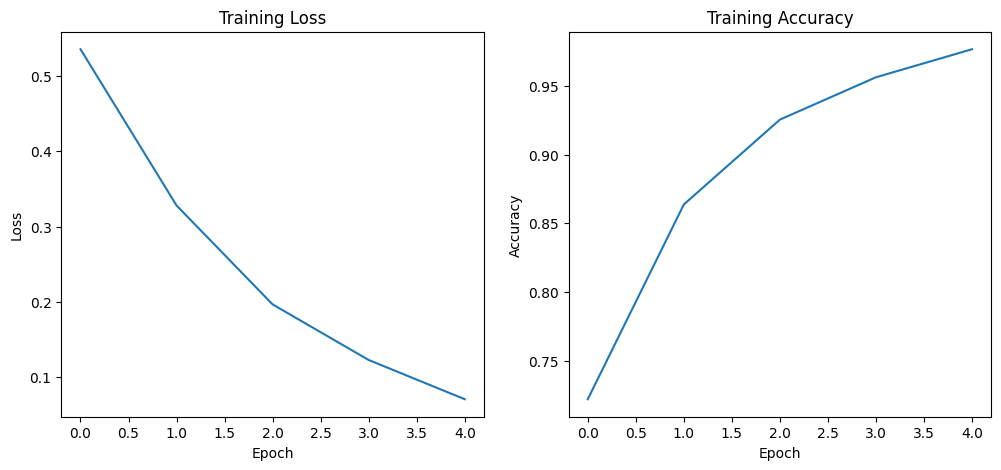

In [14]:
# Plot training loss and accuracy
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

In [15]:
# Evaluate the model on test data
model.eval()
all_preds = []
all_probs = []

with torch.no_grad():
    for inputs, labels in DataLoader(list(zip(x_test_tensor, y_test_tensor)), batch_size=batch_size):
        outputs = model(inputs)
        probs = outputs.squeeze().cpu().numpy()
        preds = np.round(probs)
        all_probs.extend(probs)
        all_preds.extend(preds)

In [16]:
accuracy = accuracy_score(y_test, all_preds)
precision = precision_score(y_test, all_preds)
recall = recall_score(y_test, all_preds)
f1 = f1_score(y_test, all_preds)
auc = roc_auc_score(y_test, all_probs)

# Print metrics
print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test Precision: {precision:.4f}')
print(f'Test Recall: {recall:.4f}')
print(f'Test F1 Score: {f1:.4f}')
print(f'Test AUC: {auc:.4f}')

Test Accuracy: 0.8717
Test Precision: 0.8556
Test Recall: 0.8943
Test F1 Score: 0.8745
Test AUC: 0.9410


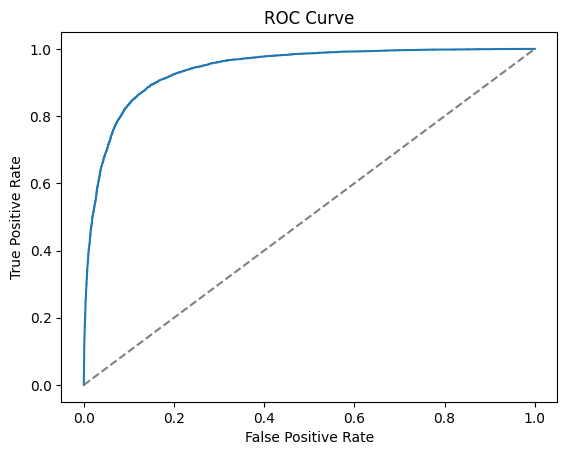

In [17]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, all_probs)
plt.figure()
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# **TENSORFLOW**

In [18]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=num_words)

In [19]:
# Pad the sequences to a fixed length
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [20]:
# Define the GRU model
model = models.Sequential()
model.add(layers.Embedding(input_dim=num_words, output_dim=128, input_length=maxlen))
model.add(layers.GRU(128, return_sequences=True, dropout=0.2))
model.add(layers.GRU(128, dropout=0.2))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [21]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
# Train the model
history = model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - accuracy: 0.6879 - loss: 0.5564 - val_accuracy: 0.8416 - val_loss: 0.3848
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - accuracy: 0.9175 - loss: 0.2194 - val_accuracy: 0.8697 - val_loss: 0.3231
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.9618 - loss: 0.1108 - val_accuracy: 0.8672 - val_loss: 0.3647
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.9732 - loss: 0.0774 - val_accuracy: 0.8666 - val_loss: 0.4054
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.9877 - loss: 0.0381 - val_accuracy: 0.8609 - val_loss: 0.6072


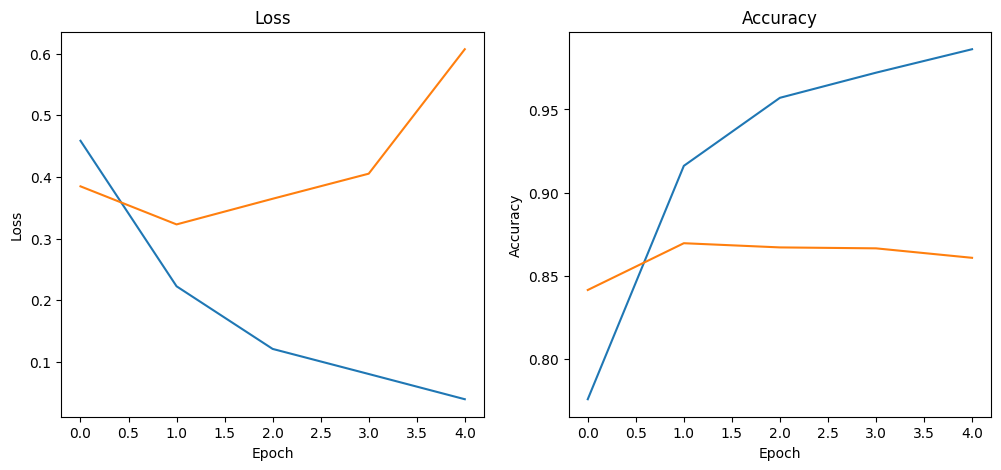

In [23]:
# Plot training loss and accuracy
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

In [24]:
# Evaluate the model on test data
y_pred = (model.predict(x_test) > 0.5).astype('int32')

782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step


In [25]:
# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

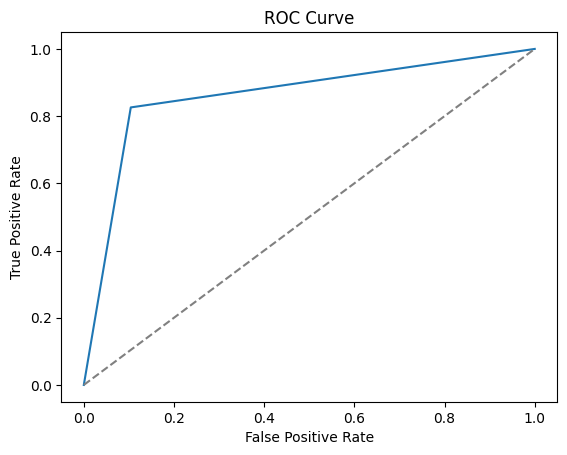

Test Accuracy: 0.8609
Test Precision: 0.8880
Test Recall: 0.8259
Test F1 Score: 0.8558
Test AUC: 0.8609


In [26]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Print metrics
print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test Precision: {precision:.4f}')
print(f'Test Recall: {recall:.4f}')
print(f'Test F1 Score: {f1:.4f}')
print(f'Test AUC: {auc:.4f}')

# **Analisis Proyek GRU Model untuk Klasifikasi Sentimen pada Dataset IMDb**

Pada proyek ini, kita menggunakan **GRU (Gated Recurrent Unit)** untuk menganalisis sentimen dari dataset IMDb, yang berisi ulasan film. Dataset ini digunakan untuk melatih model dengan tujuan mengklasifikasikan ulasan sebagai Positif atau Negatif. Model ini diimplementasikan menggunakan dua framework deep learning yaitu PyTorch dan TensorFlow, dan dievaluasi dengan berbagai metrik.

#### **Hasil Evaluasi**:

##### **PyTorch**
- **Test Accuracy**: 0.8717
- **Test Precision**: 0.8556
- **Test Recall**: 0.8943
- **Test F1 Score**: 0.8745
- **Test AUC**: 0.9410

##### **TensorFlow**
- **Test Accuracy**: 0.8609
- **Test Precision**: 0.8880
- **Test Recall**: 0.8259
- **Test F1 Score**: 0.8558
- **Test AUC**: 0.8609

---

### **Penjelasan untuk Metrik Evaluasi**

Untuk mengevaluasi kinerja model GRU ini, kita menggunakan metrik yang umum dalam klasifikasi biner seperti Akurasi, Presisi, Recall, F1 Score, dan AUC. Berikut adalah penjelasan matematis dan interpretasi dari masing-masing metrik.

---

#### **1. Akurasi (Accuracy)**

Akurasi mengukur seberapa banyak prediksi yang benar dari total prediksi yang dilakukan oleh model. Akurasi dihitung dengan membandingkan jumlah prediksi yang benar dengan total jumlah data.


$$\text{Accuracy} = \frac{\text{Jumlah Prediksi yang Benar}}{\text{Jumlah Total Prediksi}}$$


**Interpretasi:**
- PyTorch Test Accuracy: 0.8717 berarti 87.17% dari prediksi yang dilakukan oleh model benar.
- TensorFlow Test Accuracy: 0.8609 berarti 86.09% dari prediksi yang dilakukan oleh model benar.

Kedua model menunjukkan akurasi yang sangat baik, dengan PyTorch sedikit lebih unggul.

---

#### **2. Presisi (Precision)**

Presisi mengukur seberapa banyak dari semua prediksi positif yang benar-benar positif. Ini sangat penting ketika kita ingin menghindari prediksi positif palsu yang banyak.


$$\text{Precision} = \frac{\text{True Positives}}{\text{True Positives + False Positives}}$$


**Interpretasi:**
- PyTorch Test Precision: 0.8556 berarti 85.56% dari semua prediksi positif yang dilakukan oleh model adalah benar.
- TensorFlow Test Precision: 0.8880 berarti 88.80% dari semua prediksi positif yang dilakukan oleh model adalah benar.

TensorFlow menunjukkan presisi yang lebih tinggi, artinya model lebih jarang membuat prediksi positif yang salah.

---

#### **3. Recall (Sensitivity)**

Recall mengukur seberapa banyak dari semua data positif yang dapat diprediksi dengan benar oleh model. Ini penting ketika kita ingin memastikan bahwa kita tidak melewatkan banyak contoh positif.


$$\text{Recall} = \frac{\text{True Positives}}{\text{True Positives + False Negatives}}$$


**Interpretasi:**
- PyTorch Test Recall: 0.8943 berarti 89.43% dari semua ulasan positif dapat diprediksi dengan benar oleh model.
- TensorFlow Test Recall: 0.8259 berarti 82.59% dari semua ulasan positif dapat diprediksi dengan benar oleh model.

PyTorch memiliki recall yang lebih tinggi, yang menunjukkan model PyTorch lebih baik dalam mendeteksi ulasan positif dibandingkan model TensorFlow.

---

#### **4. F1 Score**

F1 Score adalah rata-rata harmonis antara presisi dan recall. Ini adalah metrik yang sangat berguna ketika kita memiliki data yang tidak seimbang (misalnya lebih banyak ulasan negatif daripada positif). F1 memberikan gambaran yang lebih seimbang antara presisi dan recall.


$$\text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}$$


**Interpretasi:**
- PyTorch Test F1 Score: 0.8745 menunjukkan keseimbangan antara presisi dan recall untuk model PyTorch.
- TensorFlow Test F1 Score: 0.8558 menunjukkan keseimbangan antara presisi dan recall untuk model TensorFlow.

F1 Score yang lebih tinggi pada PyTorch menunjukkan bahwa model tersebut memiliki keseimbangan yang lebih baik antara presisi dan recall.

---

#### **5. AUC (Area Under the Curve)**

AUC mengukur area di bawah kurva ROC (Receiver Operating Characteristic). Kurva ROC adalah plot yang menunjukkan seberapa baik model dapat membedakan antara kelas positif dan negatif. AUC adalah skor yang menunjukkan performa keseluruhan model. AUC yang lebih tinggi menunjukkan model yang lebih baik dalam membedakan antara dua kelas.


$$\text{AUC} = \text{Area di bawah kurva ROC}$$


**Interpretasi:**
- PyTorch Test AUC: 0.9410 berarti model PyTorch memiliki kemampuan yang sangat baik untuk membedakan antara ulasan positif dan negatif, dengan area di bawah kurva yang mendekati 1.
- TensorFlow Test AUC: 0.8609 berarti model TensorFlow juga menunjukkan kemampuan yang baik, meskipun lebih rendah dibandingkan dengan model PyTorch.

AUC yang lebih tinggi pada PyTorch menunjukkan bahwa model ini lebih efektif dalam membedakan antara ulasan positif dan negatif.

---

### **Kesimpulan**

**Kinerja Model**:
- **Model PyTorch**: Model ini memiliki akurasi dan AUC yang lebih tinggi dibandingkan dengan model TensorFlow. Meskipun presisi model TensorFlow sedikit lebih tinggi, recall dan F1 score model PyTorch lebih unggul. AUC yang lebih tinggi pada PyTorch menunjukkan bahwa model ini lebih baik dalam membedakan antara ulasan positif dan negatif.
- **Model TensorFlow**: Model TensorFlow menunjukkan presisi yang lebih tinggi, tetapi recall dan F1 score sedikit lebih rendah dibandingkan dengan PyTorch. Meskipun AUC lebih rendah, model ini masih sangat efektif dalam mendeteksi ulasan positif.

**Tuning dan Performa**:
- Performa model dapat lebih ditingkatkan dengan tuning lebih lanjut pada hyperparameters seperti jumlah layer GRU, ukuran hidden layer, atau menggunakan teknik regularisasi untuk mencegah overfitting.
  
**Penggunaan AUC**:
- AUC yang tinggi menunjukkan bahwa kedua model ini sangat baik dalam membedakan antara kelas positif dan negatif, meskipun PyTorch sedikit lebih unggul dalam hal ini.
